In [ ]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 300
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=3, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
splitNN.selected['client_1'] = True
splitNN.selected['client_2'] = False
splitNN.selected['client_3'] = True
splitNN.selected['client_4'] = True

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



170
50
Epoch 0 - Training loss: 2.102083206176758
Epoch 0 - Test loss: 1.7175002098083496
Epoch 1 - Training loss: 1.4732518196105957
Epoch 1 - Test loss: 1.250218152999878
Epoch 2 - Training loss: 1.1603493690490723
Epoch 2 - Test loss: 1.0649346113204956
Epoch 3 - Training loss: 1.0197486877441406
Epoch 3 - Test loss: 0.9641034603118896
Epoch 4 - Training loss: 0.9385276436805725
Epoch 4 - Test loss: 0.8937998414039612
Epoch 5 - Training loss: 0.8942126035690308
Epoch 5 - Test loss: 0.8806065917015076
Epoch 6 - Training loss: 0.8550236821174622
Epoch 6 - Test loss: 0.7999898791313171
Epoch 7 - Training loss: 0.8159968256950378
Epoch 7 - Test loss: 0.7762451767921448
Epoch 8 - Training loss: 0.7713885307312012
Epoch 8 - Test loss: 0.7449117302894592
Epoch 9 - Training loss: 0.7470781207084656
Epoch 9 - Test loss: 0.7321581244468689
Epoch 10 - Training loss: 0.727308452129364
Epoch 10 - Test loss: 0.7217614054679871
Epoch 11 - Training loss: 0.7095520496368408
Epoch 11 - Test loss: 0.7

In [ ]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 300
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=2, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
splitNN.selected['client_1'] = True
splitNN.selected['client_2'] = False
splitNN.selected['client_3'] = False
splitNN.selected['client_4'] = True

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()



179
50
Epoch 0 - Training loss: 2.2641799449920654
Epoch 0 - Test loss: 2.189990997314453
Epoch 1 - Training loss: 2.102710485458374
Epoch 1 - Test loss: 2.0225412845611572
Epoch 2 - Training loss: 1.9570090770721436
Epoch 2 - Test loss: 1.8834341764450073
Epoch 3 - Training loss: 1.8673425912857056
Epoch 3 - Test loss: 1.8078275918960571
Epoch 4 - Training loss: 1.8101359605789185
Epoch 4 - Test loss: 1.7652615308761597
Epoch 5 - Training loss: 1.7670711278915405
Epoch 5 - Test loss: 1.7316631078720093
Epoch 6 - Training loss: 1.7313810586929321
Epoch 6 - Test loss: 1.7117842435836792
Epoch 7 - Training loss: 1.7000031471252441
Epoch 7 - Test loss: 1.695765733718872
Epoch 8 - Training loss: 1.67636239528656
Epoch 8 - Test loss: 1.6707042455673218
Epoch 9 - Training loss: 1.6590676307678223
Epoch 9 - Test loss: 1.663667917251587
Epoch 10 - Training loss: 1.6561565399169922
Epoch 10 - Test loss: 1.6355358362197876
Epoch 11 - Training loss: 1.6246974468231201
Epoch 11 - Test loss: 1.7325

170
50
Epoch 0 - Training loss: 2.275858163833618
Epoch 0 - Test loss: 2.220261335372925
Epoch 1 - Training loss: 2.147751569747925
Epoch 1 - Test loss: 2.096313953399658
Epoch 2 - Training loss: 2.04622483253479
Epoch 2 - Test loss: 2.007115125656128
Epoch 3 - Training loss: 1.9787206649780273
Epoch 3 - Test loss: 1.9490886926651
Epoch 4 - Training loss: 1.9282424449920654
Epoch 4 - Test loss: 1.9151824712753296
Epoch 5 - Training loss: 1.8993855714797974
Epoch 5 - Test loss: 1.8880926370620728
Epoch 6 - Training loss: 1.8777451515197754
Epoch 6 - Test loss: 1.8668290376663208
Epoch 7 - Training loss: 1.8603062629699707
Epoch 7 - Test loss: 1.8552135229110718
Epoch 8 - Training loss: 1.8459171056747437
Epoch 8 - Test loss: 1.8437855243682861
Epoch 9 - Training loss: 1.8337217569351196
Epoch 9 - Test loss: 1.8328545093536377
Epoch 10 - Training loss: 1.8609864711761475
Epoch 10 - Test loss: 1.8338158130645752
Epoch 11 - Training loss: 1.8490573167800903
Epoch 11 - Test loss: 1.82458400

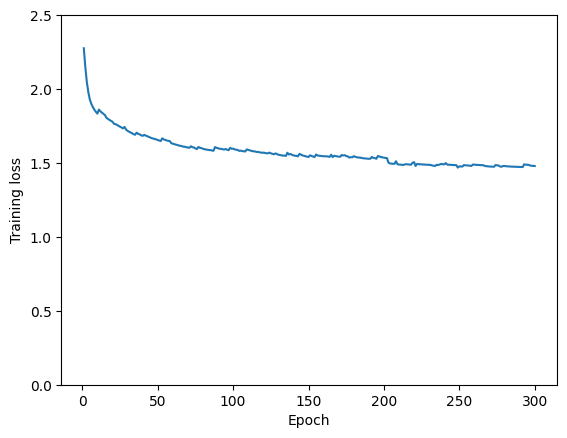

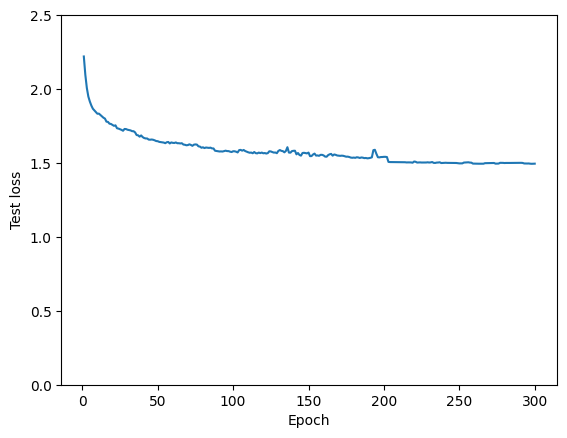

In [1]:
def update_learning_rate(i, splitNN):
    lr_a = 0.3
    if i > 200:
        lr_a = 0.05
    if i > 400:
        lr_a = 0.01
    if i > 500:
        lr_a = 0.001
    optimizers = [
        (optim.SGD(models[location.id].parameters(), lr=lr_a,), location)
        for location in model_locations
    ]
    
    splitNN.set_lr(optimizers)
    return

EPOCHS = 300
SUBSET_UPDATE_PROB = 0.2
PADDING_METHOD = "zeros"
LEARNING_RATE = 0.3
GROUP_TESTING_ROUNDS = 5
res = []

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import random
from time import process_time

from src.psi.util import Client, Server
from src.discrete_splitnn import DiscreteSplitNN
from src.utils import add_ids
from src.discrete_distribute_data import DiscreteDistributeMNIST

hook = sy.TorchHook(torch)

# Data preprocessing
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64
                                          , shuffle=True)

# create some workers
client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")
client_3 = sy.VirtualWorker(hook, id="client_3")
client_4 = sy.VirtualWorker(hook, id="client_4")
server = sy.VirtualWorker(hook, id= "server") 

data_owners = (client_1, client_2, client_3, client_4)
model_locations = [client_1, client_2, client_3, client_4, server]

#Split each image and send one part to client_1, and other to client_2
distributed_trainloader = DiscreteDistributeMNIST(data_owners=data_owners, data_loader=trainloader)

torch.manual_seed(0)

# Define our model segments

input_size= [28*7, 28*7, 28*7, 28*7]
hidden_sizes= {"client_1": [128, 64], "client_2":[128, 64], "client_3": [128, 64], "client_4":[128, 64], "server":[256, 128]}
output_size = 10

models = {
    "client_1": nn.Sequential(
                nn.Linear(input_size[0], hidden_sizes["client_1"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_1"][0], hidden_sizes["client_1"][1]),
                nn.ReLU(),
    ),
    "client_2":  nn.Sequential(
                nn.Linear(input_size[1], hidden_sizes["client_2"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_2"][0], hidden_sizes["client_2"][1]),
                nn.ReLU(),
    ),
    "client_3":  nn.Sequential(
                nn.Linear(input_size[2], hidden_sizes["client_3"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_3"][0], hidden_sizes["client_3"][1]),
                nn.ReLU(),
    ),
    "client_4":  nn.Sequential(
                nn.Linear(input_size[3], hidden_sizes["client_4"][0]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["client_4"][0], hidden_sizes["client_4"][1]),
                nn.ReLU(),
    ),
    "server": nn.Sequential(
                nn.Linear(hidden_sizes["server"][0], hidden_sizes["server"][1]),
                nn.ReLU(),
                nn.Linear(hidden_sizes["server"][1], 10),
                nn.LogSoftmax(dim=1)
    )
}

# Create optimisers for each segment and link to them
optimizers = [
    (optim.SGD(models[location.id].parameters(), lr=LEARNING_RATE,), location)
    for location in model_locations
]

for location in model_locations:
    models[location.id].send(location)


#Instantiate a SpliNN class with our distributed segments and their respective optimizers
splitNN = DiscreteSplitNN(models, server, data_owners, optimizers, distributed_trainloader, k=10, n_selected=1, padding_method=PADDING_METHOD)

distributed_trainloader.generate_subdata()
splitNN.selected['client_1'] = False
splitNN.selected['client_2'] = False
splitNN.selected['client_3'] = False
splitNN.selected['client_4'] = True

test_perf = []
performance = []
print(len(distributed_trainloader.distributed_subdata))
print(len(distributed_trainloader.test_set))
for i in range(EPOCHS):
    running_loss = 0
    test_loss = 0
    if (random.random() < SUBSET_UPDATE_PROB):
        distributed_trainloader.generate_subdata()
    
    #iterate over each datapoint 
    for _, data_ptr, label in distributed_trainloader.distributed_subdata:
        
        #send labels to server's location for training
        label = label.send(server)
        
        loss = splitNN.train(data_ptr, label)
        running_loss += loss
    
    for data_ptr, label in distributed_trainloader.test_set:
        label = label.send(server)
        
        loss = splitNN.eval(data_ptr, label)
        test_loss += loss
    
    test_perf.append((test_loss/len(distributed_trainloader.test_set)).item())
    performance.append((running_loss/len(distributed_trainloader.distributed_subdata)).item())
    print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader.distributed_subdata)))
    print("Epoch {} - Test loss: {}".format(i, test_loss/len(distributed_trainloader.test_set)))
    update_learning_rate(i, splitNN)


res.append(performance)
plt.plot(range(1, EPOCHS+1), performance)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

plt.plot(range(1, EPOCHS+1), test_perf)
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.ylim([0,2.5])
plt.show()

